In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
np.random.seed(221)

# Stochastic simulation

In [2]:
# Stochastic simulation function (SSA)

def gillespie_2D(stop_time, parameters, initial_state):
    # Gillespie simulation of a specific stochastic model.
    # Inputs the stop time for the simulation, a list of model parameters, and species initial values
    # Outputs an array of reaction times and an array of species over time
    
    # Initializing the time and the species:
    X = initial_state[:]
    iteration_time = 0
    
    # Parameters assignment:
    k1 = parameters[0]
    K1 = parameters[1]
    hill = parameters[2]
    k2 = parameters[3]
    g1 = parameters[4]
    g2 = parameters[5]

    # Initialize output:
    Xt0 = [X[0]]
    Xt1 = [X[1]]
    reaction_times = [iteration_time]
    
    # Propensity functions:
    F1 = k1/(1+K1*X[1]**hill)
    F2 = g1*X[0]
    F3 = k2*X[0]
    F4 = g2*X[1]

    # Run reactions
    while iteration_time < stop_time:

        # Generating u[0] for next reaction time and u[1] for choosing a reaction:
        u = np.random.rand(2)

        # Propensity functions update:
        F1 = k1/(1+K1*X[1]**hill)
        F2 = g1*X[0]
        F3 = k2*X[0]
        F4 = g2*X[1]
        S = F1+F2+F3+F4

        # Time update (next reaction time):
        iteration_time += -(1/S)*np.log(u[0])

        # A reaction occurs, then species update:
        reactions = [F1/S,F2/S,F3/S,F4/S]

            # Reaction 1 occurs:
        if u[1]<reactions[0]:
            X[0] += 1
            # Reaction 2 occurs:
        if reactions[0]<u[1] and u[1] < reactions[0]+reactions[1]:
            X[0] += -1
            # Reaction 3 occurs:
        if reactions[0]+reactions[1]<u[1] and u[1]<reactions[0]+reactions[1]+reactions[2]:
            X[1] += 1
            # Reaction 4 occurs:
        if reactions[0]+reactions[1]+reactions[2]<u[1] :
            X[1] += -1            
            
            # Update outputs:
        Xt0.append(X[0])
        Xt1.append(X[1])
        reaction_times.append(iteration_time)
    
    Xt = [np.array(Xt0),np.array(Xt1)]
        
    return np.array(reaction_times), Xt

# Measurements

In [3]:
# 'Measurements from simulation' function

def Measurements(reaction_times, Xt, stop_time, measure_step=10, measure_start=10):
    # Takes measurements at selected times from a given stochastic run
    # Inputs the outputs of the simulation, reaction times array and species over time,
    # a stop time of measurements, a time step for measurements, and
    # an option to include the initial measurement, because the calculus excludes the first measurement
    # Outputs the measurement times and measurements
    
    # Initialize outputs:
    measurements0 = []
    measurements1 = []
    m_time = np.arange(measure_start, stop_time, measure_step)
    
    # Take measurements in fixed times:
    j = 0
    for i in range(len(reaction_times)):
        if reaction_times[i] >= m_time[j]:
            measurements0.append(Xt[0][i-1])
            measurements1.append(Xt[1][i-1])
            j += 1
        if j == len(m_time):
            break
            
    measurements = [np.array(measurements0), np.array(measurements1)]    
    
    return m_time, measurements

# Independent measurements

In [4]:
# 'Independent measurements from simulation' function

def ind_Measurements(stop_time, parameters, initial_state, measure_step=10, measure_len=10, measure_start=10):
    # Takes measurements from multiple simulations so that measurements are independent
    # Inputs the simulation function's inputs and structure of measure times
    # Outputs measurement times and measurements

    # Initialize outputs
    ind_measurements0 = []
    ind_measurements1 = []
    ind_measurements_t = []

    # Take one measurement from each simulation run
    for i in range(measure_len):

        # Simulate
        reaction_times_i, Xt_i = gillespie_2D(stop_time=stop_time, parameters=parameters, initial_state=initial_state)

        # Take measurements
        m_time_i , measurements_i = Measurements(reaction_times=reaction_times_i, Xt=Xt_i, stop_time=stop_time, measure_step=measure_step, measure_start=measure_start)
        
        # Consider just one of them (the ith)
        ind_measurements0.append(measurements_i[0][i])
        ind_measurements1.append(measurements_i[1][i])
        ind_measurements_t.append(m_time_i[i])

    ind_measurements = [np.array(ind_measurements0),np.array(ind_measurements1)]

    return np.array(ind_measurements_t), ind_measurements

# Deterministic

In [5]:
# Deterministic solution function

def Deterministic(step, dt, parameters, initial_state):
    # Calculates the deterministic solution of the model at time steps*dt
    # Inputs the number of time steps covered by the solution, the infinitesimal time dt,
    # the parameters of the model, and the initial state of species
    # Outputs an array of time steps, an array of the solution phi(t=steps*dt), and
    # the deterministic solution function to be used in other computations
    
    # Initialize outputs
    phi0_t = []
    phi1_t = []
    time = [] 
    
    # Model function, with the differential system
    def model(t,y,parameters):
        k1 = parameters[0]
        K1 = parameters[1]
        hill = parameters[2]
        k2 = parameters[3]
        g1 = parameters[4]
        g2 = parameters[5]
        return[k1/(1+K1*y[1]**hill)-g1*y[0],k2*y[0]-g2*y[1]]
    
    # Solution time
    iter_time = [x*dt for x in range(step)]
    
    # Solution object and solve
    J = ode_solver()
    J.function = model
    J.ode_solve(y_0=initial_state, t_span=iter_time, params=parameters)
    sol = J.solution
    
    # Take solutions
    for i in range(len(sol)):
        time.append(sol[i][0])
        phi0_t.append(sol[i][1][0])
        phi1_t.append(sol[i][1][1])
    
    phi_t = [np.array(phi0_t), np.array(phi1_t)]    
    
    return np.array(time), phi_t, J

# Linear noise approximation

In [6]:
# LNA solution function

def LNA(step, dt, parameters, initial_state):
    # Calculates the LNA approximation of the model for deterministic initial states
    # Inputs variables of time = step*dt, the model parameters, and the initial state
    # Outputs the time vector, the mean trajectory, the variance trajectory, and the solved object J
    
    # Initialize outputs and iteration times
    phi0_t = []
    phi1_t = []
    var00_t = []
    var01_t = []
    var10_t = []
    var11_t = []
    time = []

    # Extended initial state, including initial covariances which for deterministic initial states are zero
    ex_initial_state = [initial_state[0], initial_state[1], 0, 0, 0, 0]
    
    # Deterministic model to solve, including the deterministic solution and the covariances
    def model_lna(t,y,parameters):
        k1 = parameters[0]
        K1 = parameters[1]
        hill = parameters[2]
        k2 = parameters[3]
        g1 = parameters[4]
        g2 = parameters[5]
        equations = []
        F = k1/(1+K1*y[1]**hill)
        dF = -k1*K1*hill*y[1]**(hill-1)/(1+K1*y[1]**hill)**2
        
        equations.append(F - g1*y[0]) # phi_0
        equations.append(k2*y[0] - g2*y[1]) # phi_1
        equations.append(-2*g1*y[2] + dF*(y[4]+y[3]) + F + g1*y[0]) # var_00
        equations.append(y[3]*(-g1-g2) + k2*y[2] + dF*y[5]) # var_01
        equations.append(y[4]*(-g1-g2) + k2*y[2] + dF*y[5] ) # var_10
        equations.append(-2*g2*y[5] + k2*(y[3]+y[4]+y[0]) + g2*y[1]) # var_11
        
        return equations
    
    # Solution time
    iter_time = [w*dt for w in range(step)]
    
    # Solution object and solve
    Js = ode_solver()
    Js.function = model_lna
    Js.ode_solve(y_0=ex_initial_state, t_span=iter_time, params=parameters)
    sols = Js.solution
        
    # Take solutions
    for i in range(len(sols)):
        time.append(sols[i][0])
        phi0_t.append(sols[i][1][0])
        phi1_t.append(sols[i][1][1])
        var00_t.append(sols[i][1][2])
        var01_t.append(sols[i][1][3])
        var10_t.append(sols[i][1][4])
        var11_t.append(sols[i][1][5])
    
    phi_t = [np.array(phi0_t), np.array(phi1_t)]
    var_t = [np.array(var00_t), np.array(var01_t), np.array(var10_t), np.array(var11_t),]
    
    return np.array(time), phi_t, var_t, Js

# LNA sampling

In [7]:
# Sample the LNA trajectory based on LNA means and variances at each time step
    
def LNA_s(time, phi_t_i, var_t_i):  
    # Samples LNA trajectory given an LNA solution
    # Inputs the outputs of LNA: time, the mean trajectory, and the variance trajectory
    # Outputs the sample time and the sample of species
    
    # Initialize outputs and iteration variables
    lna_sample = []
    lna_time = []
    i = 0
    
    # Sample trajectory for each 10 time steps, for better visualization
    while i < len(var_t_i):
        S_t = phi_t_i[i] + sqrt(var_t_i[i])*np.random.normal() # Density is a gaussian (solution of LNA)
        lna_sample.append(S_t)
        lna_time.append(time[i])
        i += 10

    lna_sample = np.array(lna_sample)
    lna_time = np.array(lna_time)
    
    return lna_time, lna_sample

# MCMC - Metropolis

In [8]:
# Markov chain monte carlo algorithm of Metropolis

def Metropolis(steps, initial_guess, proposal_var, m_time, measurements, step, dt, initial_state):
    # Metropolis algorithm to sample from the posterior from measurements; the posterior is of
    # a chosen parameter of the model. Sampling from this posterior, we have a bayesian inference for the parameter
    # Inputs the number of accepted steps, the initial guess for the parameter, the variance of the gaussian
    # proposal function (to be adjusted for good convergence), the initial state of species, measurement times, and 
    # the measured species
    # Outputs the mcmc chain for the parameter 

    # Initialize parameters and outputs
    Hi = initial_guess # Can be chosen randomly by the prior
    MCMC = [Hi]
    
    # Initialize count variables
    count = 0
    i = 0
    
    # Create index proxy for measurement times
    m_index = m_time/dt

    # MCMC iteration
    while i < steps:

        # Proposal step, a new parameter is chosen:
        Hn = Hi + np.sqrt(proposal_var)*np.random.normal() # Gaussian, symmetrical, proposal function
        
        # Initialize posteriors with exponential priors:
        Posterior_H = np.exp(Hi/initial_guess)/initial_guess
        Posterior_Hn = np.exp(Hn/initial_guess)/initial_guess
        
        # Run LNA likelihoods with the old and new parameters
        time, phi_t, var_t, Js = LNA(step=step,dt=dt,parameters=[1.0, 0.1, Hi, 2.0, 0.1, 0.1],initial_state=initial_state)
        time_n, phi_t_n, var_t_n, Js_n = LNA(step=step,dt=dt,parameters=[1.0, 0.1, Hn, 2.0, 0.1, 0.1],initial_state=initial_state)

        # Iterate for the rest of measurements
        for j in range(len(measurements[1])):
            # Iteration gives the calculus of the posterior
            # Calculate posteriors with the LNA likelihood evaluated at measurements
            
                # Old parameters
            measure_density = ((2*pi*var_t[3][int(m_index[j])])**(-0.5))*np.exp(-(measurements[1][j]-phi_t[1][int(m_index[j])])**2/(2*var_t[3][int(m_index[j])]))
            Posterior_H = Posterior_H*measure_density

                # New parameters
            measure_density_n = ((2*pi*var_t_n[3][int(m_index[j])])**(-0.5))*np.exp(-(measurements[1][j]-phi_t_n[1][int(m_index[j])])**2/(2*var_t_n[3][int(m_index[j])]))
            Posterior_Hn = Posterior_Hn*measure_density_n

        # Acceptance step:
        
        ratio = float(Posterior_Hn/Posterior_H) # Acceptance ratio (for symmetrical proposal)
        
        if ratio >= 1: # Always accept new parameters
            Hi = Hn
            MCMC.append(Hi)
            i += 1
            
        else: # Accept new parameters by the ratio
            u = np.random.rand()
            print(Hi, Hn)
            
            if u < ratio:
                Hi = Hn
                i += 1
                MCMC.append(Hi)
        
        count += 1
        
        # Add tracking:
        if count % 10 == 0:
            print(count, ' - ', i)
        
        
    # Add acceptance ratio log:
    print('Acceptance ratio: ', i, '/', count)
            
    return np.array(MCMC)

# Results

In [9]:
# Model definition
initial_state = [20,20]
parameters = [1.0, 0.1, 1, 2.0, 0.1, 0.1]
stop_time = 200
dt = 0.1
step = 2000

initial_guess = 2.0
proposal_var = 0.01

In [10]:
# Take simulation
reaction_times, Xt = gillespie_2D(stop_time=stop_time,parameters=parameters,initial_state=initial_state)

Text(0.5,0,'Time')

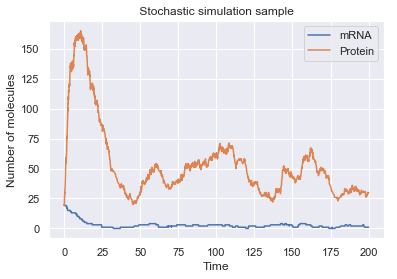

In [11]:
# Plot of simulation
plt.plot(reaction_times,Xt[0])
plt.plot(reaction_times,Xt[1])

plt.legend(['mRNA', 'Protein'])
plt.title(r""" Stochastic simulation sample """)
plt.ylabel('Number of molecules')
plt.xlabel("Time")

In [12]:
# Simulation approximate equilibrium means
Xt[0][500:].mean(), Xt[1][500:].mean()

(2.603506787330317, 59.98246606334842)

In [13]:
# Take independent measurements
m_time, measurements = ind_Measurements(stop_time, parameters, initial_state, measure_step=10, measure_len=19, measure_start=1)

Text(0.5,0,'Time')

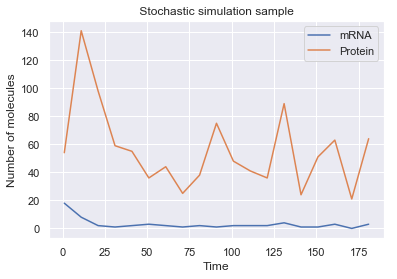

In [14]:
# Plot measurements
plt.plot(m_time,measurements[0])
plt.plot(m_time,measurements[1])

plt.legend(['mRNA', 'Protein'])
plt.title(r""" Stochastic simulation sample """)
plt.ylabel('Number of molecules')
plt.xlabel("Time")

In [15]:
# Calculate deterministic solution
time, phi_t, J = Deterministic(step=step, dt=dt, parameters=parameters, initial_state=initial_state)

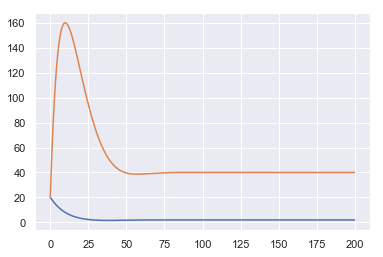

In [16]:
# Plot deterministic solution
plt.plot(time,phi_t[0])
plt.plot(time,phi_t[1])

In [17]:
# Deterministic equilibrium means
phi_t[0][-1], phi_t[1][-1]

(1.9999999676635503, 39.99999895801781)

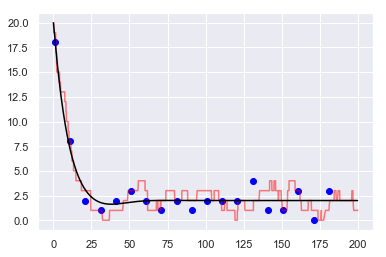

In [18]:
# mRNA plot of deterministic, simulation, and measurements
plt.scatter(m_time,measurements[0], marker='o' ,c='blue')
plt.plot(reaction_times,Xt[0], alpha=0.5, c='red')
plt.plot(time,phi_t[0], c='black')

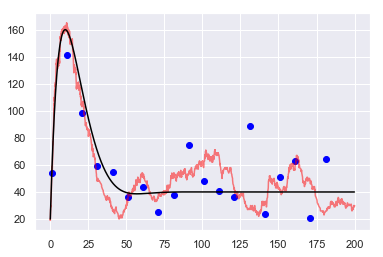

In [19]:
# Protein plot of deterministir, simulation, and measurements
plt.scatter(m_time,measurements[1], marker='o' ,c='blue')
plt.plot(reaction_times,Xt[1], alpha=0.5, c='red')
plt.plot(time,phi_t[1], c='black')

In [20]:
# Calculate LNA moment trajectories
time, phi_t, var_t, Js = LNA(step=step,dt=dt,parameters=parameters,initial_state=initial_state)

In [21]:
# Sample a LNA protein trajectory
lna_time, p_lna_s = LNA_s(time,phi_t[1],var_t[3])

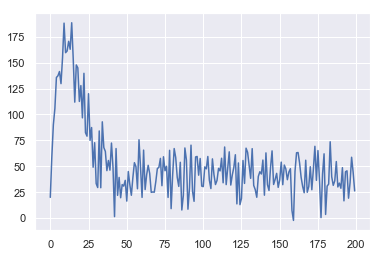

In [22]:
# Plot of LNA protein
plt.plot(lna_time,p_lna_s)

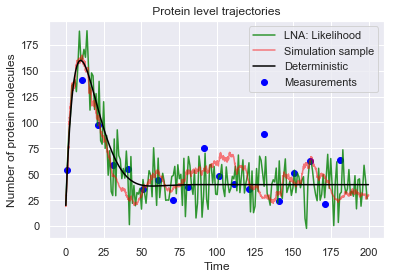

In [61]:
# Plot of LNA protein with deterministic, simulation, and measurements
plt.plot(lna_time,p_lna_s, alpha= 0.8, c='green')
plt.scatter(m_time,measurements[1], marker='o' ,c='blue')
plt.plot(reaction_times,Xt[1], alpha=0.5, c='red')
plt.plot(time,phi_t[1], c='black')
plt.legend(['LNA: Likelihood', 'Simulation sample', 'Deterministic', 'Measurements'])

plt.title(r""" Protein level trajectories """)
plt.ylabel('Number of protein molecules')
plt.xlabel("Time")

plt.savefig('protein.png')

In [24]:
# Sample a LNA mRNA trajectory
lna_time, mr_lna_s = LNA_s(time,phi_t[0],var_t[0])

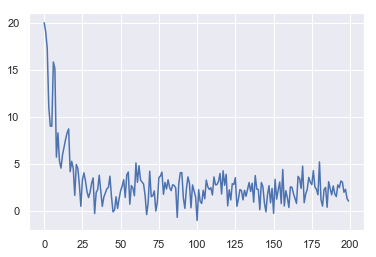

In [25]:
# Plot LNA mRNA
plt.plot(lna_time,mr_lna_s)

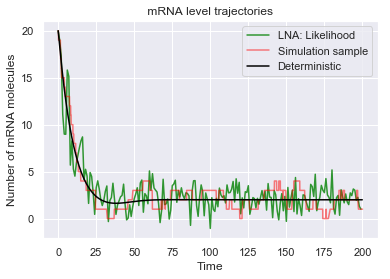

In [60]:
# Plot LNA mRNA with deterministic, simulation, and measurements
plt.plot(lna_time,mr_lna_s, alpha= 0.8, c='green')
# plt.scatter(m_time,measurements[0], marker='o' ,c='blue')
plt.plot(reaction_times,Xt[0], alpha=0.5, c='red')
plt.plot(time,phi_t[0], c='black')
plt.legend(['LNA: Likelihood', 'Simulation sample', 'Deterministic', 'Measurements'])

plt.title(r""" mRNA level trajectories """)
plt.ylabel('Number of mRNA molecules')
plt.xlabel("Time")

plt.savefig('mRNA.png')

In [27]:
# Run the MCMC algorithm
mcmc = Metropolis(steps=500, initial_guess=initial_guess, proposal_var=proposal_var, m_time=m_time, measurements=measurements, step=step, dt=dt, initial_state=initial_state)

1.907237499755306 1.9934660019387564
1.907237499755306 1.9177301294031635
1.907237499755306 1.9743885558372536
1.7424356993363215 1.7945705757234693
10  -  6
1.7022531813058754 1.7127191029184323
1.7022531813058754 1.7317663282563454
1.7022531813058754 1.8294049552546103
1.7022531813058754 1.73437916294331
1.579941755662832 1.6400662888172595
1.4284256054023945 1.4439499440051828
1.4284256054023945 1.561793160380871
20  -  9
0.9252583022218419 0.8422099864145802
0.9252583022218419 0.7279894197236764
0.9252583022218419 1.0410086781825947
0.9252583022218419 0.9519089650902425
0.9519089650902425 0.9677427624582942
0.9677427624582942 1.0755442596016123
30  -  15
0.9677427624582942 1.0589199376804008
0.9287656893829115 0.8408442509379256
0.9287656893829115 0.8807465071235777
0.8807465071235777 0.8441727171533254
0.8807465071235777 0.8253817616509591
0.8807465071235777 0.7710086217042588
40  -  20
0.9187374809570379 0.8807586404096349
0.8807586404096349 0.9835453261608471
0.8807586404096349 

0.8217334186464783 1.0514238410646728
0.8217334186464783 0.7733446639792961
0.8217334186464783 0.770454977640101
0.8806207043509787 1.1148822639534202
300  -  152
0.9020243154088873 1.01801033176862
0.8971721537198956 0.8573402375636262
0.9285974929587818 0.948157020750373
0.948157020750373 0.7882741962444542
0.948157020750373 0.9894541712028173
310  -  161
0.9679727014525434 1.1605501759745056
0.9679727014525434 1.025987637942074
0.9125270557241879 0.8041851434628056
0.9125270557241879 0.9502924282329985
0.9125270557241879 0.8809789352613339
0.8809789352613339 0.5145199749994509
0.8809789352613339 0.7609090624332817
320  -  165
0.8963777716026434 0.9648765661090185
0.8963777716026434 0.9861849832215146
0.8963777716026434 0.8411630651035137
0.8963777716026434 0.9725737999968853
0.8963777716026434 0.8246025584595109
0.8963777716026434 0.8425731604720869
0.9236688929355454 0.9815579386064192
0.9236688929355454 0.8051159295883092
0.9236688929355454 0.9433715494589835
330  -  167
0.9433715

0.9734620538108653 1.1003083848597444
0.9718901170265685 0.8065254664381676
0.9718901170265685 1.0142763454398243
0.9779599187695727 1.1608465679380564
580  -  297
0.8909486989216445 0.8739119354406496
0.8909486989216445 0.6762075502268
0.91401188982047 0.881445947682364
0.881445947682364 0.8157335655060005
0.881445947682364 0.8216046066358811
0.881445947682364 0.8098165270761227
590  -  302
0.881445947682364 1.142711284610564
0.881445947682364 0.8237388955398508
0.881445947682364 0.845338196243805
0.9455704562704255 1.0273059092968118
1.0273059092968118 1.043937265432288
1.043937265432288 1.1309112840892697
0.9776694264005452 0.7860552169675314
600  -  307
0.9262112951286604 0.9532622909909942
0.9532622909909942 1.116344275701055
0.9532622909909942 1.0015937730452504
0.9532622909909942 1.0088886514385051
0.9532622909909942 0.8669912001117897
0.8669912001117897 0.9914044028246382
0.8669912001117897 0.7231844806145491
0.906570421553142 0.7491356660166351
610  -  311
0.906570421553142 1.

0.933455530246215 1.0448391152883014
0.9099907753011548 0.7903867999012728
0.9099907753011548 0.8172012022949517
860  -  433
0.9099907753011548 0.7925054258150227
0.9099907753011548 0.9800836967146723
0.9099907753011548 1.0401106306187087
0.9099907753011548 1.0367189334780016
0.9227818850674742 1.0517633651152232
0.9227818850674742 0.7992254850826637
0.9227818850674742 0.9401127163702138
0.9051112035502367 0.6982220018967511
870  -  437
0.9051112035502367 1.0574891380987002
0.9051112035502367 1.0387755529104536
0.9051112035502367 0.9637657099373973
0.9637657099373973 1.1036680651928785
0.9637657099373973 0.9725558388012205
0.9189751382918155 0.83706367671721
0.9189751382918155 0.9348886039866285
0.9348886039866285 0.9927819457696062
0.9348886039866285 1.0287621100444566
880  -  442
0.8846414458508518 0.7343406677057176
0.8846414458508518 1.0162603261416174
0.8846414458508518 0.8739327065486799
0.8739327065486799 0.9932936988682732
0.8739327065486799 0.8185091085927074
0.873932706548679

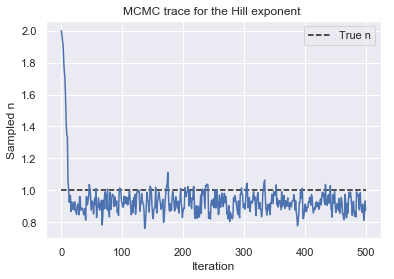

In [82]:
# Plot mcmc trace
plt.plot(np.arange(0,len(mcmc),1),mcmc)

plt.title(r"""MCMC trace for the Hill exponent """)
plt.ylabel('Sampled n')
plt.xlabel("Iteration")

plt.hlines(1, 0, 500, linestyle="--", label="True n")
plt.legend(loc="upper right")

plt.savefig('mcmc_trace.png')

In [34]:
# Parameter point estimation
mcmc_sample = mcmc[50:]
mcmc_sample.mean(), mcmc_sample.std()

(0.9201066587442344, 0.05618299667540447)

<input>:12: DeprecationWarning: invalid escape sequence \o
<input>:12: DeprecationWarning: invalid escape sequence \o
<input>:12: DeprecationWarning: invalid escape sequence \o
<input>:12: DeprecationWarning: invalid escape sequence \o
<input>:12: DeprecationWarning: invalid escape sequence \o
<input>:12: DeprecationWarning: invalid escape sequence \o
<input>:12: DeprecationWarning: invalid escape sequence \o
<input>:12: DeprecationWarning: invalid escape sequence \o
<input>:12: DeprecationWarning: invalid escape sequence \o
<ipython-input-84-1c01f02d3499>:12: DeprecationWarning: invalid escape sequence \o
  plt.annotate("$\overline{n}=0.92 \pm 0.06$", xy=(RealNumber('1.02'),RealNumber('5.0')), bbox=bbox_props)


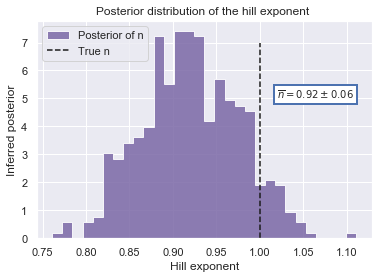

In [84]:
# Plot of parameter posterior inferred distribution

plt.hist(mcmc_sample, histtype='stepfilled', bins=30, alpha=0.85, label="Posterior of n", color="#7A68A6", density=True)
plt.vlines(1, 0, 7, linestyle="--", label="True n")
plt.legend(loc="upper left")
plt.title(r"""Posterior distribution of the hill exponent """)
plt.ylabel('Inferred posterior')
plt.xlabel("Hill exponent")
#plt.xlim([0.5, 1.5])

bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="b", lw=2)
plt.annotate("$\overline{n}=0.92 \pm 0.06$", xy=(1.02,5.0), bbox=bbox_props)

plt.savefig('mcmc_density.png')

In [45]:
# Take various simulations

reaction_times1, Xt1 = gillespie_2D(stop_time=stop_time,parameters=parameters,initial_state=initial_state)
reaction_times2, Xt2 = gillespie_2D(stop_time=stop_time,parameters=parameters,initial_state=initial_state)
reaction_times3, Xt3 = gillespie_2D(stop_time=stop_time,parameters=parameters,initial_state=initial_state)
reaction_times4, Xt4 = gillespie_2D(stop_time=stop_time,parameters=parameters,initial_state=initial_state)
reaction_times5, Xt5 = gillespie_2D(stop_time=stop_time,parameters=parameters,initial_state=initial_state)

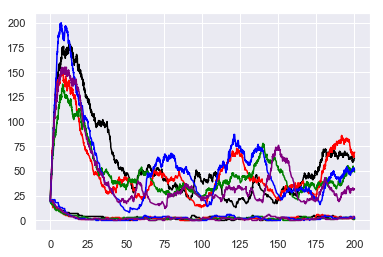

In [47]:
plt.plot(reaction_times1,Xt1[0], c='black')
plt.plot(reaction_times1,Xt1[1], c='black')

plt.plot(reaction_times2,Xt2[0], c='red')
plt.plot(reaction_times2,Xt2[1], c='red')

plt.plot(reaction_times3,Xt3[0], c='green')
plt.plot(reaction_times3,Xt3[1], c='green')

plt.plot(reaction_times4,Xt4[0], c='blue')
plt.plot(reaction_times4,Xt4[1], c='blue')

plt.plot(reaction_times5,Xt5[0], c='purple')
plt.plot(reaction_times5,Xt5[1], c='purple')



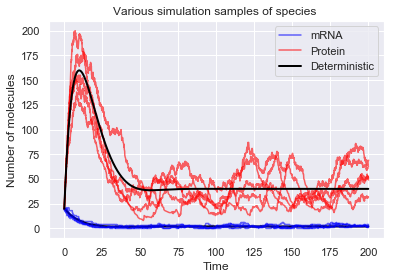

In [68]:
plt.plot(reaction_times1,Xt1[0], c='blue', alpha=0.6)
plt.plot(reaction_times1,Xt1[1], c='red', alpha=0.6)

plt.plot(time,phi_t[0], c='black', lw=2)


plt.plot(reaction_times2,Xt2[0], c='blue', alpha=0.6)
plt.plot(reaction_times2,Xt2[1], c='red', alpha=0.6)

plt.plot(reaction_times3,Xt3[0], c='blue', alpha=0.6)
plt.plot(reaction_times3,Xt3[1], c='red', alpha=0.6)

plt.plot(reaction_times4,Xt4[0], c='blue', alpha=0.6)
plt.plot(reaction_times4,Xt4[1], c='red', alpha=0.6)

plt.plot(reaction_times5,Xt5[0], c='blue', alpha=0.6)
plt.plot(reaction_times5,Xt5[1], c='red', alpha=0.6)

plt.plot(time,phi_t[1], c='black', lw=2)

plt.legend(['mRNA', 'Protein', 'Deterministic'], loc="upper right")
plt.title(r"""Various simulation samples of species """)
plt.ylabel('Number of molecules')
plt.xlabel("Time")

plt.savefig('gillespies.png')